In [1]:
# !pip install gymnasium
# !pip install mpi4py

In [2]:
import numpy as np
import torch
from torch.optim import Adam
import gymnasium as gym
import time
import matplotlib.pyplot as plt
# from logx import EpochLogger
# from mpi_pytorch import setup_pytorch_for_mpi, sync_params, mpi_avg_grads
# from mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from mpi4py import MPI
import json
import joblib
import shutil
import numpy as np
import torch
import os.path as osp, time, atexit, os
import warnings
# from mpi_tools import proc_id, mpi_statistics_scalar
# from serialization_utils import convert_json
import numpy as np
import scipy.signal
from gymnasium.spaces import Box, Discrete

import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
import multiprocessing
import numpy as np
import os
import torch
# from mpi4py import MPI
# from mpi_tools import broadcast, mpi_avg, num_procs, proc_id
import json
# from mpi4py import MPI
import os, subprocess, sys
import numpy as np

# from user_config import DEFAULT_DATA_DIR, FORCE_DATESTAMP, \
#                                DEFAULT_SHORTHAND, WAIT_BEFORE_LAUNCH
# from logx import colorize
# from mpi_tools import mpi_fork, msg
# from serialization_utils import convert_json
import base64
from copy import deepcopy
import cloudpickle
import json
import numpy as np
import os
import os.path as osp
import psutil
import string
import subprocess
from subprocess import CalledProcessError
import sys
from textwrap import dedent
import time
from tqdm import trange
import zlib





[JARVIS:02716] shmem: mmap: an error occurred while determining whether or not /var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T//ompi.JARVIS.502/jf.0/717553664/sm_segment.JARVIS.502.2ac50000.0 could be created.


In [3]:
import os
import os.path as osp

# Default neural network backend for each algo
# (Must be either 'tf1' or 'pytorch')
DEFAULT_BACKEND = {
    'vpg': 'pytorch',
    'trpo': 'tf1',
    'ppo': 'pytorch',
    'ddpg': 'pytorch',
    'td3': 'pytorch',
    'sac': 'pytorch'
}

# Where experiment outputs are saved by default:
# Function to get the current script directory
def get_script_dir():
    try:
        # Attempt to use __file__
        return osp.dirname(osp.abspath(__file__))
    except NameError:
        # Fallback for environments where __file__ is not defined
        # This assumes the current working directory is the script directory
        return osp.abspath('.')

# Where experiment outputs are saved by default:
DEFAULT_DATA_DIR = osp.join(
    osp.dirname(get_script_dir()),
    'data'
)

# Whether to automatically insert a date and time stamp into the names of
# save directories:
FORCE_DATESTAMP = False

# Whether GridSearch provides automatically-generated default shorthands:
DEFAULT_SHORTHAND = True

# Tells the GridSearch how many seconds to pause for before launching
# experiments.
WAIT_BEFORE_LAUNCH = 5

In [4]:
def mpi_fork(n, bind_to_core=False):
    """
    Re-launches the current script with workers linked by MPI.

    Also, terminates the original process that launched it.

    Taken almost without modification from the Baselines function of the
    `same name`_.

    .. _`same name`: https://github.com/openai/baselines/blob/master/baselines/common/mpi_fork.py

    Args:
        n (int): Number of process to split into.

        bind_to_core (bool): Bind each MPI process to a core.
    """
    if n<=1:
        return
    if os.getenv("IN_MPI") is None:
        env = os.environ.copy()
        env.update(
            MKL_NUM_THREADS="1",
            OMP_NUM_THREADS="1",
            IN_MPI="1"
        )
        args = ["mpirun", "-np", str(n)]
        if bind_to_core:
            args += ["-bind-to", "core"]
        args += [sys.executable] + sys.argv
        subprocess.check_call(args, env=env)
        sys.exit()


def msg(m, string=''):
    print(('Message from %d: %s \t '%(MPI.COMM_WORLD.Get_rank(), string))+str(m))

def proc_id():
    """Get rank of calling process."""
    return MPI.COMM_WORLD.Get_rank()

def allreduce(*args, **kwargs):
    return MPI.COMM_WORLD.Allreduce(*args, **kwargs)

def num_procs():
    """Count active MPI processes."""
    return MPI.COMM_WORLD.Get_size()

def broadcast(x, root=0):
    MPI.COMM_WORLD.Bcast(x, root=root)

def mpi_op(x, op):
    x, scalar = ([x], True) if np.isscalar(x) else (x, False)
    x = np.asarray(x, dtype=np.float32)
    buff = np.zeros_like(x, dtype=np.float32)
    allreduce(x, buff, op=op)
    return buff[0] if scalar else buff

def mpi_sum(x):
    return mpi_op(x, MPI.SUM)

def mpi_avg(x):
    """Average a scalar or vector over MPI processes."""
    return mpi_sum(x) / num_procs()

def mpi_statistics_scalar(x, with_min_and_max=False):
    """
    Get mean/std and optional min/max of scalar x across MPI processes.

    Args:
        x: An array containing samples of the scalar to produce statistics
            for.

        with_min_and_max (bool): If true, return min and max of x in
            addition to mean and std.
    """
    x = np.array(x, dtype=np.float32)
    global_sum, global_n = mpi_sum([np.sum(x), len(x)])
    mean = global_sum / global_n

    global_sum_sq = mpi_sum(np.sum((x - mean)**2))
    std = np.sqrt(global_sum_sq / global_n)  # compute global std

    if with_min_and_max:
        global_min = mpi_op(np.min(x) if len(x) > 0 else np.inf, op=MPI.MIN)
        global_max = mpi_op(np.max(x) if len(x) > 0 else -np.inf, op=MPI.MAX)
        return mean, std, global_min, global_max
    return mean, std

In [5]:
def convert_json(obj):
    """ Convert obj to a version which can be serialized with JSON. """
    if is_json_serializable(obj):
        return obj
    else:
        if isinstance(obj, dict):
            return {convert_json(k): convert_json(v)
                    for k,v in obj.items()}

        elif isinstance(obj, tuple):
            return (convert_json(x) for x in obj)

        elif isinstance(obj, list):
            return [convert_json(x) for x in obj]

        elif hasattr(obj,'__name__') and not('lambda' in obj.__name__):
            return convert_json(obj.__name__)

        elif hasattr(obj,'__dict__') and obj.__dict__:
            obj_dict = {convert_json(k): convert_json(v)
                        for k,v in obj.__dict__.items()}
            return {str(obj): obj_dict}

        return str(obj)

def is_json_serializable(v):
    try:
        json.dumps(v)
        return True
    except:
        return False

In [6]:
def setup_pytorch_for_mpi():
    """
    Avoid slowdowns caused by each separate process's PyTorch using
    more than its fair share of CPU resources.
    """
    #print('Proc %d: Reporting original number of Torch threads as %d.'%(proc_id(), torch.get_num_threads()), flush=True)
    if torch.get_num_threads()==1:
        return
    fair_num_threads = max(int(torch.get_num_threads() / num_procs()), 1)
    torch.set_num_threads(fair_num_threads)
    #print('Proc %d: Reporting new number of Torch threads as %d.'%(proc_id(), torch.get_num_threads()), flush=True)

def mpi_avg_grads(module):
    """ Average contents of gradient buffers across MPI processes. """
    if num_procs()==1:
        return
    for p in module.parameters():
        p_grad_numpy = p.grad.numpy()   # numpy view of tensor data
        avg_p_grad = mpi_avg(p.grad)
        p_grad_numpy[:] = avg_p_grad[:]

def sync_params(module):
    """ Sync all parameters of module across all MPI processes. """
    if num_procs()==1:
        return
    for p in module.parameters():
        p_numpy = p.data.numpy()
        broadcast(p_numpy)

In [7]:
"""

Some simple logging functionality, inspired by rllab's logging.

Logs to a tab-separated-values file (path/to/output_directory/progress.txt)

"""

color2num = dict(
    gray=30,
    red=31,
    green=32,
    yellow=33,
    blue=34,
    magenta=35,
    cyan=36,
    white=37,
    crimson=38
)

def colorize(string, color, bold=False, highlight=False):
    """
    Colorize a string.

    This function was originally written by John Schulman.
    """
    attr = []
    num = color2num[color]
    if highlight: num += 10
    attr.append(str(num))
    if bold: attr.append('1')
    return '\x1b[%sm%s\x1b[0m' % (';'.join(attr), string)

class Logger:
    """
    A general-purpose logger.

    Makes it easy to save diagnostics, hyperparameter configurations, the
    state of a training run, and the trained model.
    """

    def __init__(self, output_dir=None, output_fname='progress.txt', exp_name=None):
        """
        Initialize a Logger.

        Args:
            output_dir (string): A directory for saving results to. If
                ``None``, defaults to a temp directory of the form
                ``/tmp/experiments/somerandomnumber``.

            output_fname (string): Name for the tab-separated-value file
                containing metrics logged throughout a training run.
                Defaults to ``progress.txt``.

            exp_name (string): Experiment name. If you run multiple training
                runs and give them all the same ``exp_name``, the plotter
                will know to group them. (Use case: if you run the same
                hyperparameter configuration with multiple random seeds, you
                should give them all the same ``exp_name``.)
        """
        if proc_id()==0:
            self.output_dir = output_dir or "/tmp/experiments/%i"%int(time.time())
            if osp.exists(self.output_dir):
                print("Warning: Log dir %s already exists! Storing info there anyway."%self.output_dir)
            else:
                os.makedirs(self.output_dir)
            self.output_file = open(osp.join(self.output_dir, output_fname), 'w')
            atexit.register(self.output_file.close)
            print(colorize("Logging data to %s"%self.output_file.name, 'green', bold=True))
        else:
            self.output_dir = None
            self.output_file = None
        self.first_row=True
        self.log_headers = []
        self.log_current_row = {}
        self.exp_name = exp_name

    def log(self, msg, color='green'):
        """Print a colorized message to stdout."""
        if proc_id()==0:
            print(colorize(msg, color, bold=True))

    def log_tabular(self, key, val):
        """
        Log a value of some diagnostic.

        Call this only once for each diagnostic quantity, each iteration.
        After using ``log_tabular`` to store values for each diagnostic,
        make sure to call ``dump_tabular`` to write them out to file and
        stdout (otherwise they will not get saved anywhere).
        """
        if self.first_row:
            self.log_headers.append(key)
        else:
            assert key in self.log_headers, "Trying to introduce a new key %s that you didn't include in the first iteration"%key
        assert key not in self.log_current_row, "You already set %s this iteration. Maybe you forgot to call dump_tabular()"%key
        self.log_current_row[key] = val

    def save_config(self, config):
        """
        Log an experiment configuration.

        Call this once at the top of your experiment, passing in all important
        config vars as a dict. This will serialize the config to JSON, while
        handling anything which can't be serialized in a graceful way (writing
        as informative a string as possible).

        Example use:

        .. code-block:: python

            logger = EpochLogger(**logger_kwargs)
            logger.save_config(locals())
        """
        config_json = convert_json(config)
        if self.exp_name is not None:
            config_json['exp_name'] = self.exp_name
        if proc_id()==0:
            output = json.dumps(config_json, separators=(',',':\t'), indent=4, sort_keys=True)
            print(colorize('Saving config:\n', color='cyan', bold=True))
            print(output)
            with open(osp.join(self.output_dir, "config.json"), 'w') as out:
                out.write(output)

    def save_state(self, state_dict, itr=None):
        """
        Saves the state of an experiment.

        To be clear: this is about saving *state*, not logging diagnostics.
        All diagnostic logging is separate from this function. This function
        will save whatever is in ``state_dict``---usually just a copy of the
        environment---and the most recent parameters for the model you
        previously set up saving for with ``setup_tf_saver``.

        Call with any frequency you prefer. If you only want to maintain a
        single state and overwrite it at each call with the most recent
        version, leave ``itr=None``. If you want to keep all of the states you
        save, provide unique (increasing) values for 'itr'.

        Args:
            state_dict (dict): Dictionary containing essential elements to
                describe the current state of training.

            itr: An int, or None. Current iteration of training.
        """
        if proc_id()==0:
            fname = 'vars.pkl' if itr is None else 'vars%d.pkl'%itr
            try:
                joblib.dump(state_dict, osp.join(self.output_dir, fname))
            except:
                self.log('Warning: could not pickle state_dict.', color='red')
            if hasattr(self, 'tf_saver_elements'):
                self._tf_simple_save(itr)
            if hasattr(self, 'pytorch_saver_elements'):
                self._pytorch_simple_save(itr)

    # def setup_tf_saver(self, sess, inputs, outputs):
    #     """
    #     Set up easy model saving for tensorflow.
    #
    #     Call once, after defining your computation graph but before training.
    #
    #     Args:
    #         sess: The Tensorflow session in which you train your computation
    #             graph.
    #
    #         inputs (dict): A dictionary that maps from keys of your choice
    #             to the tensorflow placeholders that serve as inputs to the
    #             computation graph. Make sure that *all* of the placeholders
    #             needed for your outputs are included!
    #
    #         outputs (dict): A dictionary that maps from keys of your choice
    #             to the outputs from your computation graph.
    #     """
    #     self.tf_saver_elements = dict(session=sess, inputs=inputs, outputs=outputs)
    #     self.tf_saver_info = {'inputs': {k:v.name for k,v in inputs.items()},
    #                           'outputs': {k:v.name for k,v in outputs.items()}}
    #
    # def _tf_simple_save(self, itr=None):
    #     """
    #     Uses simple_save to save a trained model, plus info to make it easy
    #     to associated tensors to variables after restore.
    #     """
    #     if proc_id()==0:
    #         assert hasattr(self, 'tf_saver_elements'), \
    #             "First have to setup saving with self.setup_tf_saver"
    #         fpath = 'tf1_save' + ('%d'%itr if itr is not None else '')
    #         fpath = osp.join(self.output_dir, fpath)
    #         if osp.exists(fpath):
    #             # simple_save refuses to be useful if fpath already exists,
    #             # so just delete fpath if it's there.
    #             shutil.rmtree(fpath)
    #         tf.saved_model.simple_save(export_dir=fpath, **self.tf_saver_elements)
    #         joblib.dump(self.tf_saver_info, osp.join(fpath, 'model_info.pkl'))


    def setup_pytorch_saver(self, what_to_save):
        """
        Set up easy model saving for a single PyTorch model.

        Because PyTorch saving and loading is especially painless, this is
        very minimal; we just need references to whatever we would like to
        pickle. This is integrated into the logger because the logger
        knows where the user would like to save information about this
        training run.

        Args:
            what_to_save: Any PyTorch model or serializable object containing
                PyTorch models.
        """
        self.pytorch_saver_elements = what_to_save

    def _pytorch_simple_save(self, itr=None):
        """
        Saves the PyTorch model (or models).
        """
        if proc_id()==0:
            assert hasattr(self, 'pytorch_saver_elements'), \
                "First have to setup saving with self.setup_pytorch_saver"
            fpath = 'pyt_save'
            fpath = osp.join(self.output_dir, fpath)
            fname = 'model' + ('%d'%itr if itr is not None else '') + '.pt'
            fname = osp.join(fpath, fname)
            os.makedirs(fpath, exist_ok=True)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # We are using a non-recommended way of saving PyTorch models,
                # by pickling whole objects (which are dependent on the exact
                # directory structure at the time of saving) as opposed to
                # just saving network weights. This works sufficiently well
                # for the purposes of Spinning Up, but you may want to do
                # something different for your personal PyTorch project.
                # We use a catch_warnings() context to avoid the warnings about
                # not being able to save the source code.
                torch.save(self.pytorch_saver_elements, fname)


    def dump_tabular(self):
        """
        Write all of the diagnostics from the current iteration.

        Writes both to stdout, and to the output file.
        """
        if proc_id()==0:
            vals = []
            key_lens = [len(key) for key in self.log_headers]
            max_key_len = max(15,max(key_lens))
            keystr = '%'+'%d'%max_key_len
            fmt = "| " + keystr + "s | %15s |"
            n_slashes = 22 + max_key_len
            print("-"*n_slashes)
            for key in self.log_headers:
                val = self.log_current_row.get(key, "")
                valstr = "%8.3g"%val if hasattr(val, "__float__") else val
                print(fmt%(key, valstr))
                vals.append(val)
            print("-"*n_slashes, flush=True)
            if self.output_file is not None:
                if self.first_row:
                    self.output_file.write("\t".join(self.log_headers)+"\n")
                self.output_file.write("\t".join(map(str,vals))+"\n")
                self.output_file.flush()
        self.log_current_row.clear()
        self.first_row=False

class EpochLogger(Logger):
    """
    A variant of Logger tailored for tracking average values over epochs.

    Typical use case: there is some quantity which is calculated many times
    throughout an epoch, and at the end of the epoch, you would like to
    report the average / std / min / max value of that quantity.

    With an EpochLogger, each time the quantity is calculated, you would
    use

    .. code-block:: python

        epoch_logger.store(NameOfQuantity=quantity_value)

    to load it into the EpochLogger's state. Then at the end of the epoch, you
    would use

    .. code-block:: python

        epoch_logger.log_tabular(NameOfQuantity, **options)

    to record the desired values.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_dict = dict()

    def store(self, **kwargs):
        """
        Save something into the epoch_logger's current state.

        Provide an arbitrary number of keyword arguments with numerical
        values.
        """
        for k,v in kwargs.items():
            if not(k in self.epoch_dict.keys()):
                self.epoch_dict[k] = []
            self.epoch_dict[k].append(v)

    def log_tabular(self, key, val=None, with_min_and_max=False, average_only=False):
        """
        Log a value or possibly the mean/std/min/max values of a diagnostic.

        Args:
            key (string): The name of the diagnostic. If you are logging a
                diagnostic whose state has previously been saved with
                'store', the key here has to match the key you used there.

            val: A value for the diagnostic. If you have previously saved
                values for this key via ``store``, do *not* provide a ``val``
                here.

            with_min_and_max (bool): If true, log min and max values of the
                diagnostic over the epoch.

            average_only (bool): If true, do not log the standard deviation
                of the diagnostic over the epoch.
        """
        if val is not None:
            super().log_tabular(key,val)
        else:
            v = self.epoch_dict[key]
            vals = np.concatenate(v) if isinstance(v[0], np.ndarray) and len(v[0].shape)>0 else v
            stats = mpi_statistics_scalar(vals, with_min_and_max=with_min_and_max)
            super().log_tabular(key if average_only else 'Average' + key, stats[0])
            if not(average_only):
                super().log_tabular('Std'+key, stats[1])
            if with_min_and_max:
                super().log_tabular('Max'+key, stats[3])
                super().log_tabular('Min'+key, stats[2])
        self.epoch_dict[key] = []

    def get_stats(self, key):
        """
        Lets an algorithm ask the logger for mean/std/min/max of a diagnostic.
        """
        v = self.epoch_dict[key]
        vals = np.concatenate(v) if isinstance(v[0], np.ndarray) and len(v[0].shape)>0 else v
        return mpi_statistics_scalar(vals)

In [8]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input:
        vector x,
        [x0,
         x1,
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Actor(nn.Module):

    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a


class MLPCategoricalActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)


class MLPGaussianActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution


class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.



class MLPActorCritic(nn.Module):


    def __init__(self, observation_space, action_space,
                 hidden_sizes=(64,64), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(obs_dim, action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation)

        # build value function
        self.v  = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [9]:
DIV_LINE_WIDTH = 80

def setup_logger_kwargs(exp_name, seed=None, data_dir=None, datestamp=False):
    """
    Sets up the output_dir for a logger and returns a dict for logger kwargs.

    If no seed is given and datestamp is false,

    ::

        output_dir = data_dir/exp_name

    If a seed is given and datestamp is false,

    ::

        output_dir = data_dir/exp_name/exp_name_s[seed]

    If datestamp is true, amend to

    ::

        output_dir = data_dir/YY-MM-DD_exp_name/YY-MM-DD_HH-MM-SS_exp_name_s[seed]

    You can force datestamp=True by setting ``FORCE_DATESTAMP=True`` in
    ``spinup/user_config.py``.

    Args:

        exp_name (string): Name for experiment.

        seed (int): Seed for random number generators used by experiment.

        data_dir (string): Path to folder where results should be saved.
            Default is the ``DEFAULT_DATA_DIR`` in ``spinup/user_config.py``.

        datestamp (bool): Whether to include a date and timestamp in the
            name of the save directory.

    Returns:

        logger_kwargs, a dict containing output_dir and exp_name.
    """

    # Datestamp forcing
    datestamp = datestamp or FORCE_DATESTAMP

    # Make base path
    ymd_time = time.strftime("%Y-%m-%d_") if datestamp else ''
    relpath = ''.join([ymd_time, exp_name])

    if seed is not None:
        # Make a seed-specific subfolder in the experiment directory.
        if datestamp:
            hms_time = time.strftime("%Y-%m-%d_%H-%M-%S")
            subfolder = ''.join([hms_time, '-', exp_name, '_s', str(seed)])
        else:
            subfolder = ''.join([exp_name, '_s', str(seed)])
        relpath = osp.join(relpath, subfolder)

    data_dir = data_dir or DEFAULT_DATA_DIR
    logger_kwargs = dict(output_dir=osp.join(data_dir, relpath),
                         exp_name=exp_name)
    return logger_kwargs


def call_experiment(exp_name, thunk, seed=0, num_cpu=1, data_dir=None,
                    datestamp=False, **kwargs):
    """
    Run a function (thunk) with hyperparameters (kwargs), plus configuration.

    This wraps a few pieces of functionality which are useful when you want
    to run many experiments in sequence, including logger configuration and
    splitting into multiple processes for MPI.

    There's also a SpinningUp-specific convenience added into executing the
    thunk: if ``env_name`` is one of the kwargs passed to call_experiment, it's
    assumed that the thunk accepts an argument called ``env_fn``, and that
    the ``env_fn`` should make a gym environment with the given ``env_name``.

    The way the experiment is actually executed is slightly complicated: the
    function is serialized to a string, and then ``run_entrypoint.py`` is
    executed in a subprocess call with the serialized string as an argument.
    ``run_entrypoint.py`` unserializes the function call and executes it.
    We choose to do it this way---instead of just calling the function
    directly here---to avoid leaking state between successive experiments.

    Args:

        exp_name (string): Name for experiment.

        thunk (callable): A python function.

        seed (int): Seed for random number generators.

        num_cpu (int): Number of MPI processes to split into. Also accepts
            'auto', which will set up as many procs as there are cpus on
            the machine.

        data_dir (string): Used in configuring the logger, to decide where
            to store experiment results. Note: if left as None, data_dir will
            default to ``DEFAULT_DATA_DIR`` from ``spinup/user_config.py``.

        **kwargs: All kwargs to pass to thunk.

    """

    # Determine number of CPU cores to run on
    num_cpu = psutil.cpu_count(logical=False) if num_cpu=='auto' else num_cpu

    # Send random seed to thunk
    kwargs['seed'] = seed

    # Be friendly and print out your kwargs, so we all know what's up
    print(colorize('Running experiment:\n', color='cyan', bold=True))
    print(exp_name + '\n')
    print(colorize('with kwargs:\n', color='cyan', bold=True))
    kwargs_json = convert_json(kwargs)
    print(json.dumps(kwargs_json, separators=(',',':\t'), indent=4, sort_keys=True))
    print('\n')

    # Set up logger output directory
    if 'logger_kwargs' not in kwargs:
        kwargs['logger_kwargs'] = setup_logger_kwargs(exp_name, seed, data_dir, datestamp)
    else:
        print('Note: Call experiment is not handling logger_kwargs.\n')

    def thunk_plus():
        # Make 'env_fn' from 'env_name'
        if 'env_name' in kwargs:
            import gym
            env_name = kwargs['env_name']
            kwargs['env_fn'] = lambda : gym.make(env_name)
            del kwargs['env_name']

        # Fork into multiple processes
        mpi_fork(num_cpu)

        # Run thunk
        thunk(**kwargs)

    # Prepare to launch a script to run the experiment
    pickled_thunk = cloudpickle.dumps(thunk_plus)
    encoded_thunk = base64.b64encode(zlib.compress(pickled_thunk)).decode('utf-8')

    entrypoint = osp.join(osp.abspath(osp.dirname(__file__)),'run_entrypoint.py')
    cmd = [sys.executable if sys.executable else 'python', entrypoint, encoded_thunk]
    try:
        subprocess.check_call(cmd, env=os.environ)
    except CalledProcessError:
        err_msg = '\n'*3 + '='*DIV_LINE_WIDTH + '\n' + dedent("""

            There appears to have been an error in your experiment.

            Check the traceback above to see what actually went wrong. The
            traceback below, included for completeness (but probably not useful
            for diagnosing the error), shows the stack leading up to the
            experiment launch.

            """) + '='*DIV_LINE_WIDTH + '\n'*3
        print(err_msg)
        raise

    # Tell the user about where results are, and how to check them
    logger_kwargs = kwargs['logger_kwargs']

    plot_cmd = 'python -m spinup.run plot '+logger_kwargs['output_dir']
    plot_cmd = colorize(plot_cmd, 'green')

    test_cmd = 'python -m spinup.run test_policy '+logger_kwargs['output_dir']
    test_cmd = colorize(test_cmd, 'green')

    output_msg = '\n'*5 + '='*DIV_LINE_WIDTH +'\n' + dedent("""\
    End of experiment.


    Plot results from this run with:

    %s


    Watch the trained agent with:

    %s


    """%(plot_cmd,test_cmd)) + '='*DIV_LINE_WIDTH + '\n'*5

    print(output_msg)


def all_bools(vals):
    return all([isinstance(v,bool) for v in vals])

def valid_str(v):
    """
    Convert a value or values to a string which could go in a filepath.

    Partly based on `this gist`_.

    .. _`this gist`: https://gist.github.com/seanh/93666

    """
    if hasattr(v, '__name__'):
        return valid_str(v.__name__)

    if isinstance(v, tuple) or isinstance(v, list):
        return '-'.join([valid_str(x) for x in v])

    # Valid characters are '-', '_', and alphanumeric. Replace invalid chars
    # with '-'.
    str_v = str(v).lower()
    valid_chars = "-_%s%s" % (string.ascii_letters, string.digits)
    str_v = ''.join(c if c in valid_chars else '-' for c in str_v)
    return str_v


class ExperimentGrid:
    """
    Tool for running many experiments given hyperparameter ranges.
    """

    def __init__(self, name=''):
        self.keys = []
        self.vals = []
        self.shs = []
        self.in_names = []
        self.name(name)

    def name(self, _name):
        assert isinstance(_name, str), "Name has to be a string."
        self._name = _name

    def print(self):
        """Print a helpful report about the experiment grid."""
        print('='*DIV_LINE_WIDTH)

        # Prepare announcement at top of printing. If the ExperimentGrid has a
        # short name, write this as one line. If the name is long, break the
        # announcement over two lines.
        base_msg = 'ExperimentGrid %s runs over parameters:\n'
        name_insert = '['+self._name+']'
        if len(base_msg%name_insert) <= 80:
            msg = base_msg%name_insert
        else:
            msg = base_msg%(name_insert+'\n')
        print(colorize(msg, color='green', bold=True))

        # List off parameters, shorthands, and possible values.
        for k, v, sh in zip(self.keys, self.vals, self.shs):
            color_k = colorize(k.ljust(40), color='cyan', bold=True)
            print('', color_k, '['+sh+']' if sh is not None else '', '\n')
            for i, val in enumerate(v):
                print('\t' + str(convert_json(val)))
            print()

        # Count up the number of variants. The number counting seeds
        # is the total number of experiments that will run; the number not
        # counting seeds is the total number of otherwise-unique configs
        # being investigated.
        nvars_total = int(np.prod([len(v) for v in self.vals]))
        if 'seed' in self.keys:
            num_seeds = len(self.vals[self.keys.index('seed')])
            nvars_seedless = int(nvars_total / num_seeds)
        else:
            nvars_seedless = nvars_total
        print(' Variants, counting seeds: '.ljust(40), nvars_total)
        print(' Variants, not counting seeds: '.ljust(40), nvars_seedless)
        print()
        print('='*DIV_LINE_WIDTH)


    def _default_shorthand(self, key):
        # Create a default shorthand for the key, built from the first
        # three letters of each colon-separated part.
        # But if the first three letters contains something which isn't
        # alphanumeric, shear that off.
        valid_chars = "%s%s" % (string.ascii_letters, string.digits)
        def shear(x):
            return ''.join(z for z in x[:3] if z in valid_chars)
        sh = '-'.join([shear(x) for x in key.split(':')])
        return sh

    def add(self, key, vals, shorthand=None, in_name=False):
        """
        Add a parameter (key) to the grid config, with potential values (vals).

        By default, if a shorthand isn't given, one is automatically generated
        from the key using the first three letters of each colon-separated
        term. To disable this behavior, change ``DEFAULT_SHORTHAND`` in the
        ``spinup/user_config.py`` file to ``False``.

        Args:
            key (string): Name of parameter.

            vals (value or list of values): Allowed values of parameter.

            shorthand (string): Optional, shortened name of parameter. For
                example, maybe the parameter ``steps_per_epoch`` is shortened
                to ``steps``.

            in_name (bool): When constructing variant names, force the
                inclusion of this parameter into the name.
        """
        assert isinstance(key, str), "Key must be a string."
        assert shorthand is None or isinstance(shorthand, str), \
            "Shorthand must be a string."
        if not isinstance(vals, list):
            vals = [vals]
        if DEFAULT_SHORTHAND and shorthand is None:
            shorthand = self._default_shorthand(key)
        self.keys.append(key)
        self.vals.append(vals)
        self.shs.append(shorthand)
        self.in_names.append(in_name)

    def variant_name(self, variant):
        """
        Given a variant (dict of valid param/value pairs), make an exp_name.

        A variant's name is constructed as the grid name (if you've given it
        one), plus param names (or shorthands if available) and values
        separated by underscores.

        Note: if ``seed`` is a parameter, it is not included in the name.
        """

        def get_val(v, k):
            # Utility method for getting the correct value out of a variant
            # given as a nested dict. Assumes that a parameter name, k,
            # describes a path into the nested dict, such that k='a:b:c'
            # corresponds to value=variant['a']['b']['c']. Uses recursion
            # to get this.
            if k in v:
                return v[k]
            else:
                splits = k.split(':')
                k0, k1 = splits[0], ':'.join(splits[1:])
                return get_val(v[k0], k1)

        # Start the name off with the name of the variant generator.
        var_name = self._name

        # Build the rest of the name by looping through all parameters,
        # and deciding which ones need to go in there.
        for k, v, sh, inn in zip(self.keys, self.vals, self.shs, self.in_names):

            # Include a parameter in a name if either 1) it can take multiple
            # values, or 2) the user specified that it must appear in the name.
            # Except, however, when the parameter is 'seed'. Seed is handled
            # differently so that runs of the same experiment, with different
            # seeds, will be grouped by experiment name.
            if (len(v)>1 or inn) and not(k=='seed'):

                # Use the shorthand if available, otherwise the full name.
                param_name = sh if sh is not None else k
                param_name = valid_str(param_name)

                # Get variant value for parameter k
                variant_val = get_val(variant, k)

                # Append to name
                if all_bools(v):
                    # If this is a param which only takes boolean values,
                    # only include in the name if it's True for this variant.
                    var_name += ('_' + param_name) if variant_val else ''
                else:
                    var_name += '_' + param_name + valid_str(variant_val)

        return var_name.lstrip('_')

    def _variants(self, keys, vals):
        """
        Recursively builds list of valid variants.
        """
        if len(keys)==1:
            pre_variants = [dict()]
        else:
            pre_variants = self._variants(keys[1:], vals[1:])

        variants = []
        for val in vals[0]:
            for pre_v in pre_variants:
                v = {}
                v[keys[0]] = val
                v.update(pre_v)
                variants.append(v)
        return variants

    def variants(self):
        """
        Makes a list of dicts, where each dict is a valid config in the grid.

        There is special handling for variant parameters whose names take
        the form

            ``'full:param:name'``.

        The colons are taken to indicate that these parameters should
        have a nested dict structure. eg, if there are two params,

            ====================  ===
            Key                   Val
            ====================  ===
            ``'base:param:a'``    1
            ``'base:param:b'``    2
            ====================  ===

        the variant dict will have the structure

        .. parsed-literal::

            variant = {
                base: {
                    param : {
                        a : 1,
                        b : 2
                        }
                    }
                }
        """
        flat_variants = self._variants(self.keys, self.vals)

        def unflatten_var(var):
            """
            Build the full nested dict version of var, based on key names.
            """
            new_var = dict()
            unflatten_set = set()

            for k,v in var.items():
                if ':' in k:
                    splits = k.split(':')
                    k0 = splits[0]
                    assert k0 not in new_var or isinstance(new_var[k0], dict), \
                        "You can't assign multiple values to the same key."

                    if not(k0 in new_var):
                        new_var[k0] = dict()

                    sub_k = ':'.join(splits[1:])
                    new_var[k0][sub_k] = v
                    unflatten_set.add(k0)
                else:
                    assert not(k in new_var), \
                        "You can't assign multiple values to the same key."
                    new_var[k] = v

            # Make sure to fill out the nested dicts.
            for k in unflatten_set:
                new_var[k] = unflatten_var(new_var[k])

            return new_var

        new_variants = [unflatten_var(var) for var in flat_variants]
        return new_variants

    def run(self, thunk, num_cpu=1, data_dir=None, datestamp=False):
        """
        Run each variant in the grid with function 'thunk'.

        Note: 'thunk' must be either a callable function, or a string. If it is
        a string, it must be the name of a parameter whose values are all
        callable functions.

        Uses ``call_experiment`` to actually launch each experiment, and gives
        each variant a name using ``self.variant_name()``.

        Maintenance note: the args for ExperimentGrid.run should track closely
        to the args for call_experiment. However, ``seed`` is omitted because
        we presume the user may add it as a parameter in the grid.
        """

        # Print info about self.
        self.print()

        # Make the list of all variants.
        variants = self.variants()

        # Print variant names for the user.
        var_names = set([self.variant_name(var) for var in variants])
        var_names = sorted(list(var_names))
        line = '='*DIV_LINE_WIDTH
        preparing = colorize('Preparing to run the following experiments...',
                             color='green', bold=True)
        joined_var_names = '\n'.join(var_names)
        announcement = f"\n{preparing}\n\n{joined_var_names}\n\n{line}"
        print(announcement)


        if WAIT_BEFORE_LAUNCH > 0:
            delay_msg = colorize(dedent("""
            Launch delayed to give you a few seconds to review your experiments.

            To customize or disable this behavior, change WAIT_BEFORE_LAUNCH in
            spinup/user_config.py.

            """), color='cyan', bold=True)+line
            print(delay_msg)
            wait, steps = WAIT_BEFORE_LAUNCH, 100
            prog_bar = trange(steps, desc='Launching in...',
                              leave=False, ncols=DIV_LINE_WIDTH,
                              mininterval=0.25,
                              bar_format='{desc}: {bar}| {remaining} {elapsed}')
            for _ in prog_bar:
                time.sleep(wait/steps)

        # Run the variants.
        for var in variants:
            exp_name = self.variant_name(var)

            # Figure out what the thunk is.
            if isinstance(thunk, str):
                # Assume one of the variant parameters has the same
                # name as the string you passed for thunk, and that
                # variant[thunk] is a valid callable function.
                thunk_ = var[thunk]
                del var[thunk]
            else:
                # Assume thunk is given as a function.
                thunk_ = thunk

            call_experiment(exp_name, thunk_, num_cpu=num_cpu,
                            data_dir=data_dir, datestamp=datestamp, **var)


def test_eg():
    eg = ExperimentGrid()
    eg.add('test:a', [1,2,3], 'ta', True)
    eg.add('test:b', [1,2,3])
    eg.add('some', [4,5])
    eg.add('why', [True,False])
    eg.add('huh', 5)
    eg.add('no', 6, in_name=True)
    return eg.variants()


## Mass Spring Damper Environment

In [10]:
class MassSpringDamperEnv(gym.Env):

    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.step_num = None
        self.last_u = None
        self.state = None
        self.done = None
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # Integrator
        self.integral_error = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-20.0, high=20.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-100, high=100, shape=(2,))

    def step(self, action):
        # Apply control action and simulate one time step using Euler integration
        force = action[0] * self.action_space.high[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.integral_error += position * self.dt

        costs = (position ** 2 + 0.1 * velocity ** 2
                 + 0.01 * self.integral_error ** 2 + 0.001 * (force ** 2)) * self.dt

        self.step_num += 1
        if self.step_num > 1000:
            self.done = True

        # early stop
        if sum(self.state > 20) > 0 or sum(self.state < -20) > 0:
            self.done = True
            costs += 10

        return self._get_obs(), -costs, self.done, False, {}

    def reset(self):
        self.state = np.random.uniform(low=-10, high=10, size=(2,))
        self.current_step = 0
        self.last_u = None
        self.done = False
        self.step_num = 0
        self.integral_error = 0

        return self._get_obs(), {}

    def _get_obs(self):
        position, velocity = (self.state + self.action_space.high[0])/(self.action_space.high[0] - self.action_space.low[0]) # normalized data
        return np.array([position, velocity], dtype=np.float32)

## Proximal Policy Optimization (PPO)

In [11]:
class PPOBuffer:
    """
    A buffer for storing trajectories experienced by a PPO agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size  # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.

        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lam)

        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size  # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = mpi_statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in data.items()}


In [12]:
class PPO:
    def __init__(self, env, ac_kwargs=None, seed=0,
        steps_per_epoch=4000, epochs=50, gamma=0.99, clip_ratio=0.2, pi_lr=3e-4,
        vf_lr=1e-3, train_pi_iters=80, train_v_iters=80, lam=0.97, max_ep_len=1000,
        target_kl=0.01, logger_kwargs=None, save_freq=10):
        self.env = env
        self.ac_kwargs = ac_kwargs or {}
        self.seed = seed
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.pi_lr = pi_lr
        self.vf_lr = vf_lr
        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.lam = lam
        self.max_ep_len = max_ep_len
        self.target_kl = target_kl
        self.logger_kwargs = logger_kwargs or {}
        setup_pytorch_for_mpi()
        self.save_freq = save_freq
        """
            Proximal Policy Optimization (by clipping),

            with early stopping based on approximate KL

            Args:
                env : The environment must satisfy the OpenAI Gym API.

                actor_critic: The constructor method for a PyTorch Module with a
                    ``step`` method, an ``act`` method, a ``pi`` module, and a ``v``
                    module. The ``step`` method should accept a batch of observations
                    and return:

                    ===========  ================  ======================================
                    Symbol       Shape             Description
                    ===========  ================  ======================================
                    ``a``        (batch, act_dim)  | Numpy array of actions for each
                                                   | observation.
                    ``v``        (batch,)          | Numpy array of value estimates
                                                   | for the provided observations.
                    ``logp_a``   (batch,)          | Numpy array of log probs for the
                                                   | actions in ``a``.
                    ===========  ================  ======================================

                    The ``act`` method behaves the same as ``step`` but only returns ``a``.

                    The ``pi`` module's forward call should accept a batch of
                    observations and optionally a batch of actions, and return:

                    ===========  ================  ======================================
                    Symbol       Shape             Description
                    ===========  ================  ======================================
                    ``pi``       N/A               | Torch Distribution object, containing
                                                   | a batch of distributions describing
                                                   | the policy for the provided observations.
                    ``logp_a``   (batch,) | Optional (only returned if batch of
                                                   | actions is given). Tensor containing
                                                   | the log probability, according to
                                                   | the policy, of the provided actions.
                                                   | If actions not given, will contain
                                                   | ``None``.
                    ===========  ================  ======================================

                    The ``v`` module's forward call should accept a batch of observations
                    and return:

                    ===========  ================  ======================================
                    Symbol       Shape             Description
                    ===========  ================  ======================================
                    ``v``        (batch,)          | Tensor containing the value estimates
                                                   | for the provided observations. (Critical:
                                                   | make sure to flatten this!)
                    ===========  ================  ======================================


                ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object
                    you provided to PPO.

                seed (int): Seed for random number generators.

                steps_per_epoch (int): Number of steps of interaction (state-action pairs)
                    for the agent and the environment in each epoch.

                epochs (int): Number of epochs of interaction (equivalent to
                    number of policy updates) to perform.

                gamma (float): Discount factor. (Always between 0 and 1.)

                clip_ratio (float): Hyperparameter for clipping in the policy objective.
                    Roughly: how far can the new policy go from the old policy while
                    still profiting (improving the objective function)? The new policy
                    can still go farther than the clip_ratio says, but it doesn't help
                    on the objective anymore. (Usually small, 0.1 to 0.3.) Typically
                    denoted by :math:`\epsilon`.

                pi_lr (float): Learning rate for policy optimizer.

                vf_lr (float): Learning rate for value function optimizer.

                train_pi_iters (int): Maximum number of gradient descent steps to take
                    on policy loss per epoch. (Early stopping may cause optimizer
                    to take fewer than this.)

                train_v_iters (int): Number of gradient descent steps to take on
                    value function per epoch.

                lam (float): Lambda for GAE-Lambda. (Always between 0 and 1,
                    close to 1.)

                max_ep_len (int): Maximum length of trajectory / episode / rollout.

                target_kl (float): Roughly what KL divergence we think is appropriate
                    between new and old policies after an update. This will get used
                    for early stopping. (Usually small, 0.01 or 0.05.)

                logger_kwargs (dict): Keyword args for EpochLogger.

                save_freq (int): How often (in terms of gap between epochs) to save
                    the current policy and value function.

            """
        # Set up logger and save configuration
        self.logger = EpochLogger(**self.logger_kwargs)
        self.logger.save_config(locals())

        # Random seed
        self.seed += 10000 * proc_id()
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Instantiate environment
        obs_dim = env.observation_space.shape
        act_dim = env.action_space.shape

        # Create actor-critic module
        self.ac = MLPActorCritic(env.observation_space, env.action_space, **self.ac_kwargs)

        # Sync params across processes
        sync_params(self.ac)

        # Count variables
        var_counts = tuple(count_vars(module) for module in [self.ac.pi, self.ac.v])
        self.logger.log('\nNumber of parameters: \t pi: %d, \t v: %d\n' % var_counts)

        # Set up experience buffer
        self.local_steps_per_epoch = int(steps_per_epoch / num_procs())
        self.buf = PPOBuffer(obs_dim, act_dim, self.local_steps_per_epoch, gamma, lam)

        # Set up optimizers for policy and value function
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = Adam(self.ac.v.parameters(), lr=vf_lr)

        # Set up model saving
        self.logger.setup_pytorch_saver(self.ac)

    # Set up function for computing PPO policy loss
    def compute_loss_pi(self, data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = self.ac.pi(obs, act)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        clipped = ratio.gt(1 + self.clip_ratio) | ratio.lt(1 - self.clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(self, data):
        obs, ret = data['obs'], data['ret']
        return ((self.ac.v(obs) - ret) ** 2).mean()


    def update(self):
        data = self.buf.get()

        pi_l_old, pi_info_old = self.compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = self.compute_loss_v(data).item()

        # Train policy with multiple steps of gradient descent
        for i in range(self.train_pi_iters):
            self.pi_optimizer.zero_grad()
            loss_pi, pi_info = self.compute_loss_pi(data)
            kl = mpi_avg(pi_info['kl'])
            if kl > 1.5 * self.target_kl:
                self.logger.log('Early stopping at step %d due to reaching max kl.' % i)
                break
            loss_pi.backward()
            mpi_avg_grads(self.ac.pi)  # average grads across MPI processes
            self.pi_optimizer.step()

        self.logger.store(StopIter=i)

        # Value function learning
        for i in range(self.train_v_iters):
            self.vf_optimizer.zero_grad()
            loss_v = self.compute_loss_v(data)
            loss_v.backward()
            mpi_avg_grads(self.ac.v)  # average grads across MPI processes
            self.vf_optimizer.step()

        # Log changes from update
        kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        self.logger.store(LossPi=pi_l_old, LossV=v_l_old,
                        KL=kl, Entropy=ent, ClipFrac=cf,
                        DeltaLossPi=(loss_pi.item() - pi_l_old),
                        DeltaLossV=(loss_v.item() - v_l_old))

    def train(self):
        # Prepare for interaction with environment
        start_time = time.time()
        o, _ = env.reset()
        ep_ret, ep_len = 0, 0

        # Main loop: collect experience in env and update/log each epoch
        for epoch in range(self.epochs):
            for t in range(self.local_steps_per_epoch):
                a, v, logp = self.ac.step(torch.as_tensor(o, dtype=torch.float32))

                next_o, r, d, _, _ = env.step(a)
                ep_ret += r
                ep_len += 1

                # save and log
                self.buf.store(o, a, r, v, logp)
                self.logger.store(VVals=v)

                # Update obs (critical!)
                o = next_o

                timeout = ep_len == self.max_ep_len
                terminal = d or timeout
                epoch_ended = t == self.local_steps_per_epoch - 1

                if terminal or epoch_ended:
                    if epoch_ended and not terminal:
                        print('Warning: trajectory cut off by epoch at %d steps.' % ep_len, flush=True)
                    # if trajectory didn't reach terminal state, bootstrap value target
                    if timeout or epoch_ended:
                        _, v, _ = self.ac.step(torch.as_tensor(o, dtype=torch.float32))
                    else:
                        v = 0
                    self.buf.finish_path(v)
                    if terminal:
                        # only save EpRet / EpLen if trajectory finished
                        self.logger.store(EpRet=ep_ret, EpLen=ep_len)
                    o, _ = env.reset()
                    ep_ret, ep_len = 0, 0

            # Save model
            if (epoch % self.save_freq == 0) or (epoch == self.epochs - 1):
                self.logger.save_state({'env': env}, None)

            # Perform PPO update!
            self.update()

            # Log info about epoch
            self.logger.log_tabular('Epoch', epoch)
            self.logger.log_tabular('EpRet', with_min_and_max=True)
            self.logger.log_tabular('EpLen', average_only=True)
            self.logger.log_tabular('VVals', with_min_and_max=True)
            self.logger.log_tabular('TotalEnvInteracts', (epoch + 1) * self.steps_per_epoch)
            self.logger.log_tabular('LossPi', average_only=True)
            self.logger.log_tabular('LossV', average_only=True)
            self.logger.log_tabular('DeltaLossPi', average_only=True)
            self.logger.log_tabular('DeltaLossV', average_only=True)
            self.logger.log_tabular('Entropy', average_only=True)
            self.logger.log_tabular('KL', average_only=True)
            self.logger.log_tabular('ClipFrac', average_only=True)
            self.logger.log_tabular('StopIter', average_only=True)
            self.logger.log_tabular('Time', time.time() - start_time)
            self.logger.dump_tabular()



Logging data to /Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/MBK/data/ppo/ppo_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "clip_ratio":	0.2,
    "env":	{
        "<MassSpringDamperEnv instance>":	{
            "action_space":	{
                "Box(-20.0, 20.0, (1,), float32)":	{
                    "_np_random":	null,
                    "_shape":	[
                        1
                    ],
                    "bounded_above":	"[ True]",
                    "bounded_below":	"[ True]",
                    "dtype":	"float32",
                    "high":	"[20.]",
                    "high_repr":	"20.0",
                    "low":	"[-20.]",
                    "low_repr":	"-20.0"
                }
            },
            "c":	0.1,
            "current_step":	0,
            "done":	null,
            "dt":	0.01,
            "integral_error":	0,
            "k":	1.0,
            "las

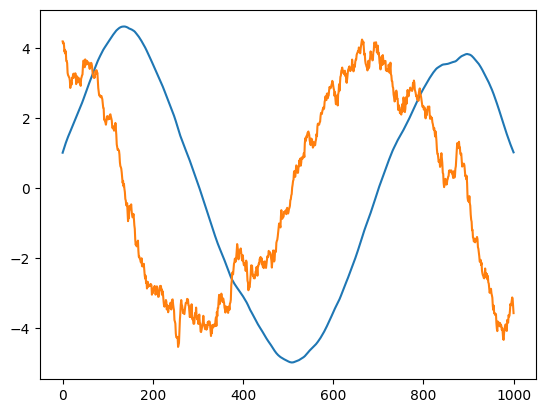

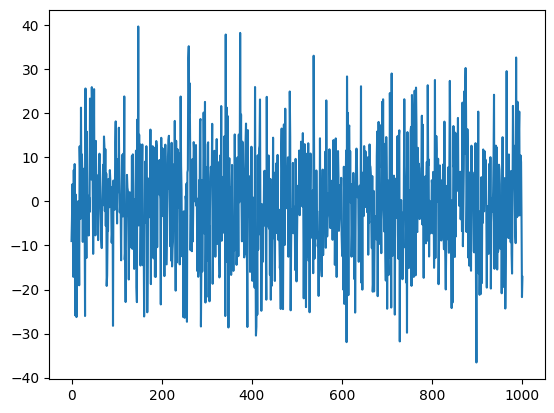

In [13]:
if __name__ == '__main__':
    # Define constants
    HID = 64
    L = 2
    GAMMA = 0.99
    SEED = 0
    STEPS = 4000
    EPOCHS = 216
    EXP_NAME = 'ppo'

    # Use the constants directly
    # from run_utils import setup_logger_kwargs
    # import core



    logger_kwargs = setup_logger_kwargs(EXP_NAME, SEED)

    ppo = PPO(MassSpringDamperEnv(), ac_kwargs=dict(hidden_sizes=[HID] * L), gamma=GAMMA,
              seed=SEED, steps_per_epoch=STEPS, epochs=EPOCHS,
              logger_kwargs=logger_kwargs)

    # test the trained model
    env = MassSpringDamperEnv()
    o, _ = env.reset()
    states = []
    actions = []
    while True:
        a, _, _ = ppo.ac.step(torch.as_tensor(o, dtype=torch.float32))
        actions.append(a*20)
        o, _, d, _, _ = env.step(a)
        states.append(o*40-20)
        if d:
            break

    plt.plot(states)
    plt.show()

    plt.plot(actions)
    plt.show()

In [14]:
ppo.train()

---------------------------------------
|             Epoch |               0 |
|      AverageEpRet |            -171 |
|          StdEpRet |             102 |
|          MaxEpRet |           -69.6 |
|          MinEpRet |            -300 |
|             EpLen |           1e+03 |
|      AverageVVals |         -0.0278 |
|          StdVVals |          0.0147 |
|          MaxVVals |         0.00894 |
|          MinVVals |         -0.0604 |
| TotalEnvInteracts |           4e+03 |
|            LossPi |       -1.24e-07 |
|             LossV |             405 |
|       DeltaLossPi |         -0.0012 |
|        DeltaLossV |            -192 |
|           Entropy |           0.919 |
|                KL |         0.00299 |
|          ClipFrac |          0.0233 |
|          StopIter |              79 |
|              Time |            14.3 |
---------------------------------------


KeyboardInterrupt: 

In [ ]:
# test the trained model
env = MassSpringDamperEnv()
o, _ = env.reset()
states = []
actions = []
while True:
    a, _, _ = ppo.ac.step(torch.as_tensor(o, dtype=torch.float32))
    actions.append(a*20)
    o, _, d, _, _ = env.step(a)
    states.append(o*40-20)
    if d:
        break

plt.plot(states)
plt.show()

plt.plot(actions)
plt.show()